# Projeto Ciencias dos Dados 3

Phelipe Müller,
Sabrina Machado e
Bruno Cury

In [ ]:
%reset -f
#pip install tmdbsimple
import pandas as pd
import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import tmdbsimple as tmdb
import seaborn as sns
import json
sns.set()
tmdb.API_KEY = 'abcd9827ce3fb2298891370ff0cd0e58'

In [215]:
#Este bloco contem funções para retirar informaçãos do API do TMDB e dos DataFrames lidos mais abaixo

def takeInfos(id):
    atores = []
    crews = []
    keywords = []

    movie = tmdb.Movies(id)

    response = movie.info()
    popularity = round(movie.popularity)
    media = round(movie.vote_average)
    title = movie.title
    for ator in movie.credits()['cast']: atores.append(ator['name'])
    for crew in movie.credits()['crew']: crews.append(crew['name'])
    for keyword in movie.keywords()['keywords']: keywords.append(keyword['name'])
    for similar in movie.similar_movies()['results']: 
        sTitles.append(similar['title'])
        sPopularity.append(round(similar["popularity"]))
        sMedia.append(round(similar["vote_average"]))
    
    return title,popularity,media,atores,crews,keywords

def takeOffInfos(line):
    atores = []
    crews = []
    keywords = []

    popularity = round(movies.iloc[line].popularity)
    media = round(movies.iloc[line].vote_average)
    title = movies.iloc[line].title
    
    i = 0
    x = credits.iloc[0].cast[i:].find('"name": ')
    y = credits.iloc[0].cast[x:].find(",")+x
    name=[credits.iloc[0].cast[x+9:y-1]]
    for i in range(2):
        i = y+16
        x = credits.iloc[0].cast[i:].find('"name": ')
        y = credits.iloc[0].cast[i+x:].find('",')+x+i
        name.append(credits.iloc[0].cast[i+x+9:y])
    atores = name
    
    x = credits.iloc[0].crew.find('"name": ')
    y = credits.iloc[0].crew[x:].find(",")+x
    crew =[credits.iloc[0].crew[x+9:y-2]]
    
    x = movies.iloc[0].keywords.find('"name": ')
    y = movies.iloc[0].keywords[x:].find(",")+x
    name=[movies.iloc[0].keywords[x+9:y-1]]
    for i in range(2):
        i = y+4
        x = movies.iloc[0].keywords[i:].find('"name": ')
        y = movies.iloc[0].keywords[i+x:].find('"},')+x+i
        name.append(movies.iloc[0].keywords[i+x+9:y])
    keywords = name
    
    return title,popularity,media,atores,crews,keywords

def NormalizeCat(X): #Não esta sendo usado
    global perda
    i = 0
    n = len(X)
    limit = 300
    if len(X)>limit:perda+=1
    while(len(X)<limit):
        if i == n: i = 0
        X.append(X[i])
        i+=1
    while(len(X)>limit):
        X.pop()
    return X
        

In [216]:
#Função para Interface de Usuario
def UI():
    Entrada = str(input("Qual filme você deseja saber a nota?"))
    search = tmdb.Search()
    response = search.movie(query=Entrada)
    if len(Search.results) == 0: print("Desculpe não encontrei nenhum filme com este nome...")
    if len(Search.resuslts) > 1:
        print("Encontrei os seguintes filmes com este nome, qual deles você deseja?")
        for i in range(len(search.results)): print(str(search.results[i]['title']) + "  [i]")
        Escolido = int(input())
    else: Escolido = 0
    X,y = Codex.Feed(search.results[Escolido]['id'])
    saida = Naive.predict([X])
    print("A nota desse filme provavelmente será {0}".format(saida[0]))
    print("For DEVS: a nota real é {0}".format(search.results[Escolido]['vote_average']))
    

In [217]:
class Encoder:
    def __init__(self,lista):
        self.Codex = []
        self.atualIndex = 1
        self.fit(lista)
        
    def fit(self,lista):
        for item in lista:
            onList = False
            for code in self.Codex:
                if item == code[0]: onList = True
            if not onList:
                self.Codex.append([item,self.atualIndex])
                self.atualIndex+=1
    
    def transform(self,lista):
        resposta = []
        for item in lista:
            for code in self.Codex:
                if item == code[0]: resposta.append(code[1])
        return resposta
    
    def fit_transform(self,lista):
        self.fit(lista)
        return self.transform(lista)
    
    def inverse_transform(self,lista):
        resposta = []
        for item in lista:
            for code in self.Codex:
                if item == code[1]: resposta.append(code[0])
        return resposta
    
    def show(self):
        print(self.Codex)
    
    def Feed(self,line):
        title,popularity,media,atores,crews,keywords = takeOffInfos(line)
        self.fit([title])
        self.fit(atores)
        self.fit(crews)
        self.fit(keywords)

        Atores = self.transform(atores)
        Crews = self.transform(crews)
        Keywords = self.transform(keywords)
        X = self.fit_transform(["P"+str(popularity/10)])
        if len(Crews)>0:X.append(Crews[0])
        else: X.append(X[-1])
        for i in range(3):
            if len(Atores)>(i): X.append(Atores[i])
            else: X.append(X[-1])

            if len(Keywords)>(i): X.append(Keywords[i])
            else: X.append(X[-1])
        y = round(media/2)
        return X,y

In [218]:
credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")

In [219]:
#Definição de banda de treino e teste baseado nos DataFrames acima 
IDlist = list(movies["id"])
n = 4000
IDTrainList = IDlist[:n]
IDTestList = IDlist[n:]

In [220]:
#Inicialização dos Classificadores e do Encoder(Criado mais a cima)
Codex = Encoder(['M0',"M1","M2",'M3','M4','M5','M6','M7','M8','M9','M10'])
Naive = MultinomialNB()
VectorMachine = svm.SVC()

In [265]:
#Treino para SVM e Naive Bayes
n = 4000
i = 0
X = []
y = []
shuffle(IDTrainList)
for i in range(len(IDTrainList)):
    X.append(Codex.Feed(i)[0])
    y.append(Codex.Feed(i)[1])
    i += 1
    if i == n:break
Naive.fit(X,y)
VectorMachine.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [266]:
#Bloco de para teste, Matriz Naive e Matriz2 SVM
i = 0
n = 803
shuffle(IDTestList)
Matriz = np.array([[0]*5]*5)
Matriz2 = np.array([[0]*5]*5)
for i in range(len(IDTestList)): 
    X,y = Codex.Feed(i)
    saida = Naive.predict([X])
    saida2 = VectorMachine.predict([X])
    
    Matriz[int(y)][int(saida[0])]+=1
    Matriz2[int(y)][int(saida2[0])]+=1

    i += 1
    if i == n:break

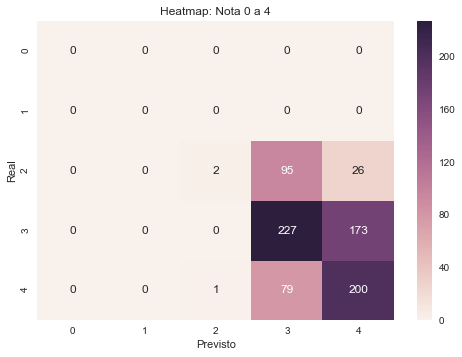

In [268]:
#Bloco usado para plotar os Graficos usados no relatorio
ax = sns.heatmap(Matriz2, annot=True,fmt='d')
plt.title("Heatmap: Nota 0 a 4")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()